In [62]:
## https://docs.pymc.io/notebooks/multilevel_modeling.html
%matplotlib inline
import numpy as np
import pandas as pd
from pymc3 import __version__
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(__version__))

from pymc3 import get_data

# Import radon data
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

Running on PyMC3 v3.6


In [63]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [64]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [4]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [5]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

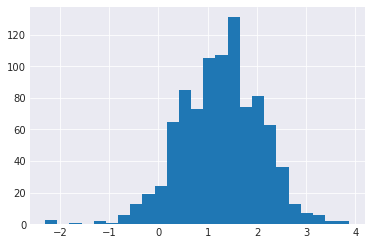

In [6]:
srrs_mn.log_radon.hist(bins=25);

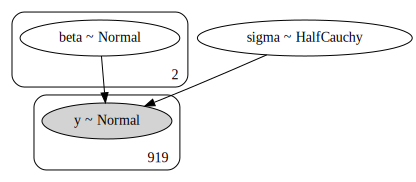

In [7]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

with Model() as pooled_model:

    beta = Normal('beta', 0, sd=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)
model_to_graphviz(pooled_model)

In [8]:
with pooled_model:
    pooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3429.77draws/s]


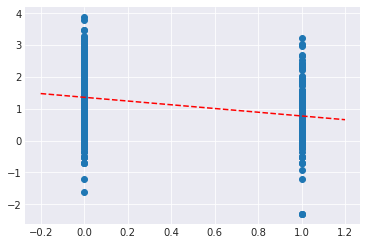

In [9]:
b0, m0 = pooled_trace['beta'].mean(axis=0)
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

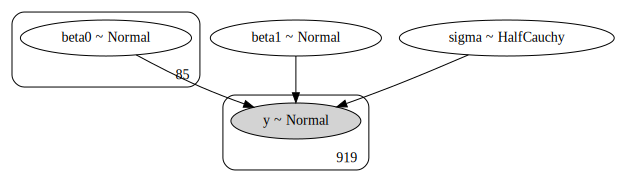

In [10]:
with Model() as unpooled_model:

    beta0 = Normal('beta0', 0, sd=1e5, shape=counties)
    beta1 = Normal('beta1', 0, sd=1e5)
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[county] + beta1*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)
model_to_graphviz(unpooled_model)

In [11]:
with unpooled_model:
    unpooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1544.99draws/s]


/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


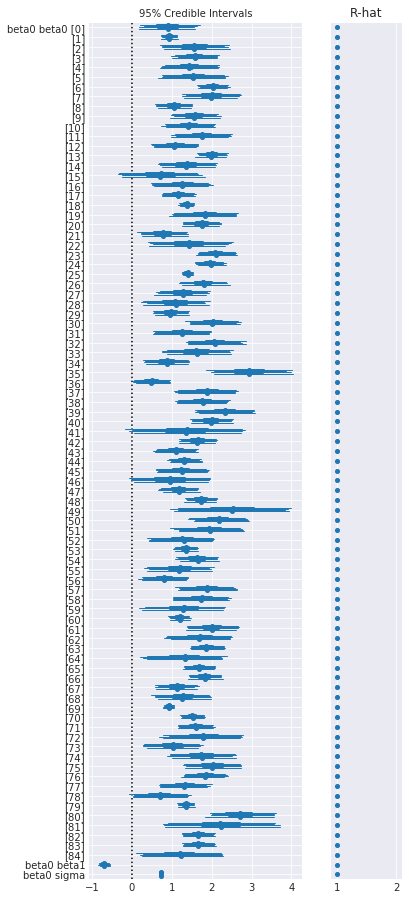

In [12]:
from pymc3 import forestplot

plt.figure(figsize=(6,14))
forestplot(unpooled_trace, ['beta0']);

In [13]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

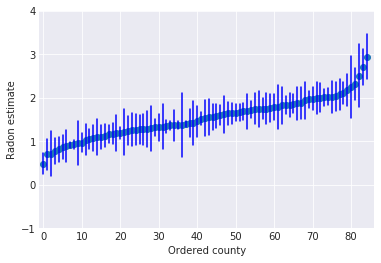

In [14]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

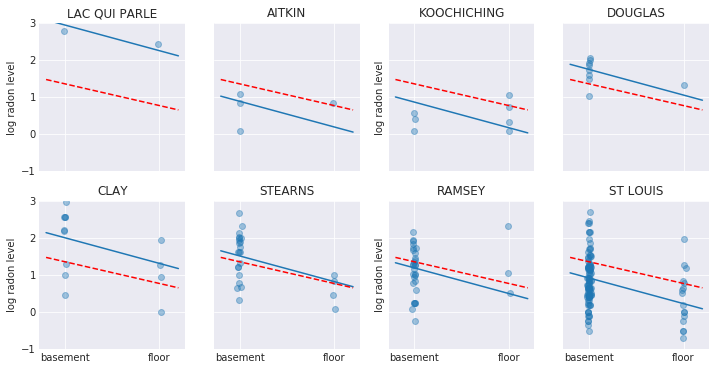

In [15]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

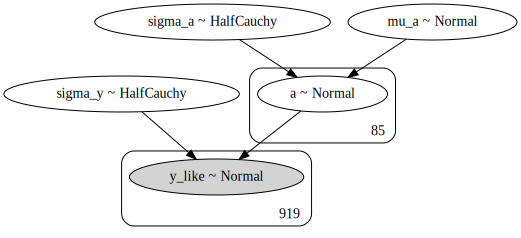

In [17]:
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[county]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(partial_pooling)

In [18]:
with partial_pooling:
    partial_pooling_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1149.76draws/s]
The number of effective samples is smaller than 25% for some parameters.


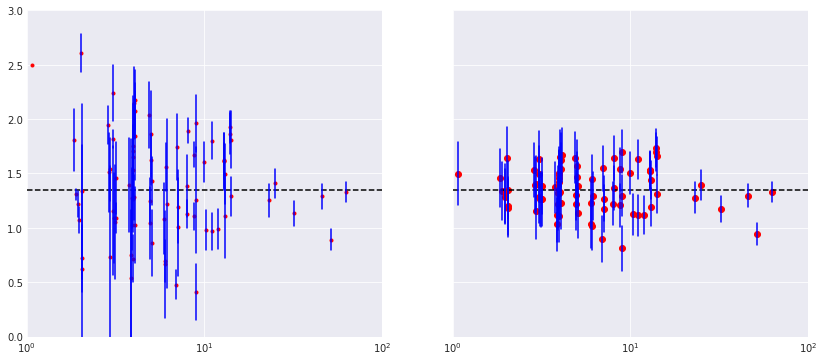

In [38]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n+jitter, unpooled.m, 'r.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means, c='r')
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

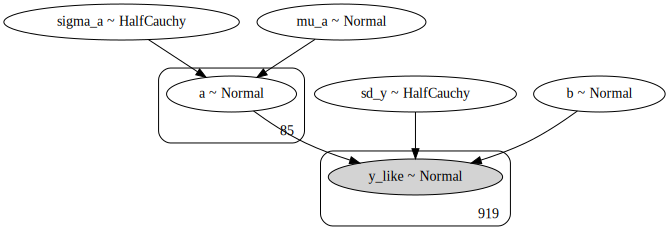

In [40]:
with Model() as varying_intercept:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)


    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Common slope
    b = Normal('b', mu=0., sd=1e5)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[county] + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=log_radon)

model_to_graphviz(varying_intercept)

In [41]:
with varying_intercept:
    varying_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_y, b, a, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1407.65draws/s]
The number of effective samples is smaller than 25% for some parameters.


/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


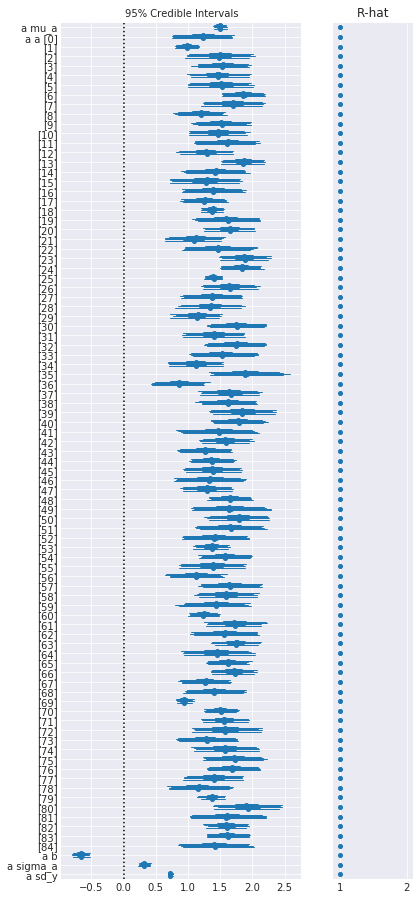

In [43]:
from pymc3 import forestplot, traceplot, plot_posterior

plt.figure(figsize=(6,14))
forestplot(varying_intercept_trace, ['a']);

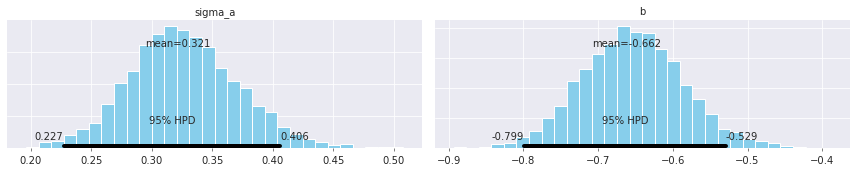

In [46]:
plot_posterior(varying_intercept_trace, ['sigma_a', 'b']);

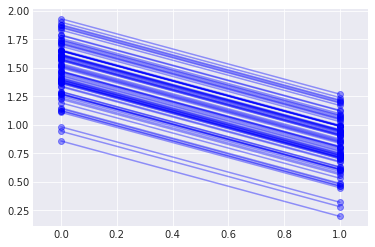

In [56]:
xvals = np.arange(2)
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

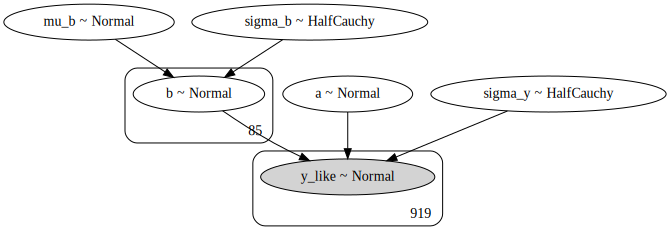

In [57]:
with Model() as varying_slope:

    # Priors
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Common intercepts
    a = Normal('a', mu=0., sd=1e5)
    # Random slopes
    b = Normal('b', mu=mu_b, sd=sigma_b, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a + b[county] * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(varying_slope)

In [58]:
with varying_slope:
    varying_slope_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:08<00:00, 957.03draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7136959982310987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6345643494733054, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/opt/conda/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


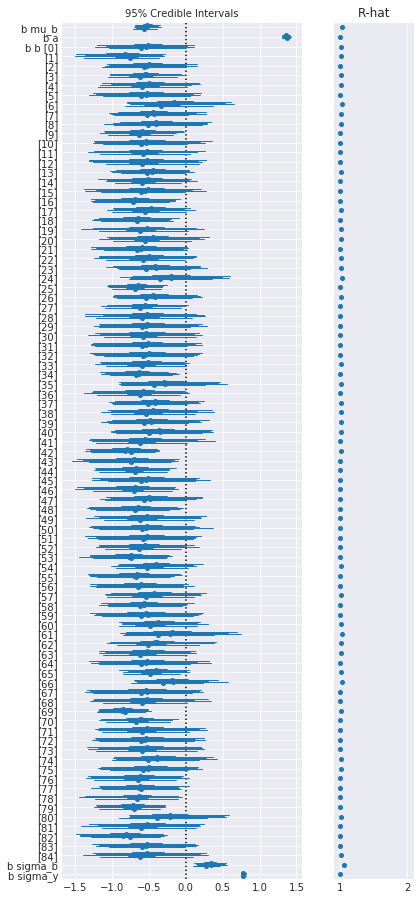

In [59]:
plt.figure(figsize=(6,14))
forestplot(varying_slope_trace, ['b']);

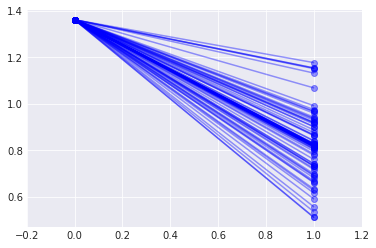

In [60]:
xvals = np.arange(2)
b = varying_slope_trace['a'].mean()
m = varying_slope_trace['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

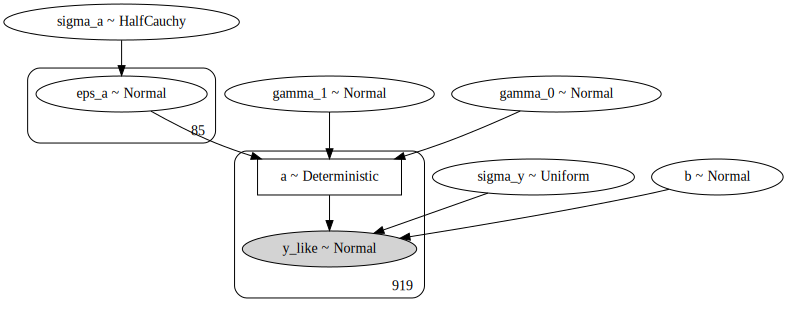

In [65]:
from pymc3 import Deterministic

with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sd=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sd=1e5)


    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(hierarchical_intercept)

In [66]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, eps_a, gamma_1, gamma_0, sigma_a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:10<00:00, 792.90draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


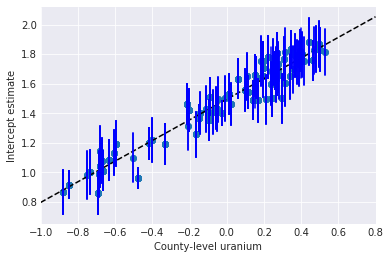

In [67]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(u, a_means)
g0 = hierarchical_intercept_trace['gamma_0'].mean()
g1 = hierarchical_intercept_trace['gamma_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(u, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate');

In [71]:
county_lookup['ST LOUIS']
# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

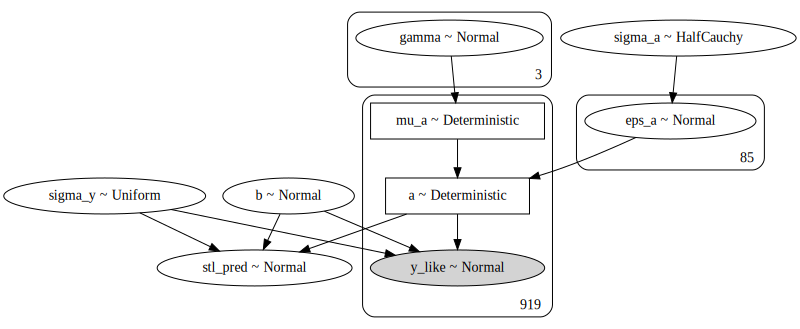

In [72]:
with Model() as contextual_pred:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma = Normal('gamma', mu=0., sd=1e5, shape=3)

    # Uranium model for intercept
    mu_a = Deterministic('mu_a', gamma[0] + gamma[1]*u.values + gamma[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sd=sigma_y)

model_to_graphviz(contextual_pred)

In [74]:
with contextual_pred:
    contextual_effect_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [stl_pred, sigma_y, b, eps_a, gamma, sigma_a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:13<00:00, 583.09draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


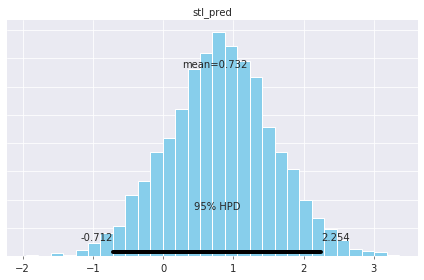

In [78]:
plot_posterior(contextual_effect_trace, ['stl_pred']);